<h1 style='text-align:center; font-size:35px; margin: 30px 0px'>Alzheimer's Disease Prediction Using Deep Learning</h1>

# 1. Project Overview
Alzheimer's disease is such a dangerous disease which causes not only the brain to shrink but also brain cells eventually die due to it.
<br>In this project we will use MRI images to first train our model and then do a prediction on an image to classify it.

# 2. Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

***
# 3. Datasets

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='Alzheimer/train',
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 5121 files belonging to 4 classes.


In [3]:
classes = dataset.class_names
classes

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

classes has folders which have photos. We divided the photos into 4 classes or folders

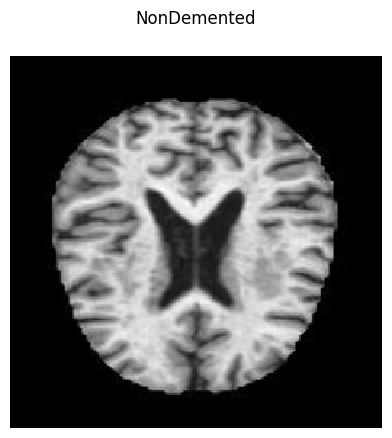

In [4]:
for image_batch, label_batch in dataset.take(1):
    plt.matshow(image_batch[0].numpy().astype('int'))
    plt.axis('off')
    plt.title(classes[label_batch[0]])

Without .astype('int') it was float so we didn't get clear picture
<br>Here classes is the list we defined above
<br><br>Now we will divide our dataset into
<br>80% ==> training
<br>20% ==> validation

In [5]:
validation_size = 0.2
validation_size * len(dataset)

32.2

In [6]:
validation_ds = dataset.take(32)
train_ds = dataset.skip(32)

In [7]:
len(validation_ds), len(train_ds), len(dataset)

(32, 129, 161)

In [8]:
train_ds_1 = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds_1 = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

cache() will read the image from the disk and for the next iteration when we need the image, it will keep it in the memory. This improves the performance
<br>shuffle(1000) will shuffle it 1000 times
<br>prefetch() will fetch the next batch from the disk if GPU is busy training (fetch is done by CPU)
<br>tf.data.AUTOTUNE means letting tensorflow determine how many batches to load

***
# 4. Neural Network

We will resize image so that if any image is not in 256x256 then it will be resized
<br>Also we scaled the image numpy values so that it is in range 0 to 1 (255 since we are keeping in view rgb). This scaling gives better performance.
<br><br>In this data augmentation part we make sure that in case we get an image which is flipped/rotated/zoomed/more or less contrast or any way different then we can deal with it by treating our data like it initially like that.

In [9]:
resized_and_rescaled = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

We are keeping image size here 256
<br>We have multiples batches each having 32 images
<br>CHANNELS = 3 refers to the number of color channels in the input images.

In [10]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

Here we will use convolution and then pooling.
<br>First we spicify 32 layers (suppose we have lion image. We can have 1 for eyes, 1 for hands, 1 for ears, 1 for nose and 1 for neck. So we get 5 layers here). More layers also keep the edges.
<br>(3,3) is actual filter size
<br>activation is relu as it is fast (we repeat it as we do both convolution and pooling multiple times)
<br><br>MaxPool2D will divide the array or data into 2x2 and then pick the max value
<br><br>Then we will flatten it as in neural network it is required
<br>Then we will add a dense layer of 64 neurons
<br>In the end we will have a layer of 3 neurons as we had 3 classes. softmax activation function will normalize the probability of the classes.

In [11]:
model = models.Sequential([
    resized_and_rescaled,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu', input_shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.build(input_shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS))

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

Now we will use adam is our optimizer which is often used. We also specified loss function and set metrics to accuracy that is we are aiming accuracy with our model.

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

We have many epochs usually such as 50. We are keeping 10 here keeping in view our system. We can notice our accuracy is improving with epochs.
<br>Also we set verbose 1 so that we can see lots of output

In [14]:
history = model.fit(
    train_ds_1,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_data=validation_ds_1,
    verbose=1,
)

Epoch 1/10


129/129 [==============================] - 207s 1s/step - loss: 1.0600 - accuracy: 0.4896 - val_loss: 1.0393 - val_accuracy: 0.4863
Epoch 2/10
129/129 [==============================] - 194s 1s/step - loss: 1.0437 - accuracy: 0.4948 - val_loss: 1.0467 - val_accuracy: 0.4863
Epoch 3/10
129/129 [==============================] - 207s 2s/step - loss: 1.0186 - accuracy: 0.5084 - val_loss: 0.9373 - val_accuracy: 0.5605
Epoch 4/10
129/129 [==============================] - 187s 1s/step - loss: 0.9622 - accuracy: 0.5367 - val_loss: 0.9352 - val_accuracy: 0.5469
Epoch 5/10
129/129 [==============================] - 197s 2s/step - loss: 0.9373 - accuracy: 0.5438 - val_loss: 0.9038 - val_accuracy: 0.5732
Epoch 6/10
129/129 [==============================] - 199s 2s/step - loss: 0.9300 - accuracy: 0.5472 - val_loss: 0.8852 - val_accuracy: 0.5840
Epoch 7/10
129/129 [==============================] - 155s 1s/step - loss: 0.9233 - accuracy: 0.5585 - val_loss: 0.9478 - val_accuracy: 0.51

***
# 5. Prediction

Now we will read the image and do prediction on it

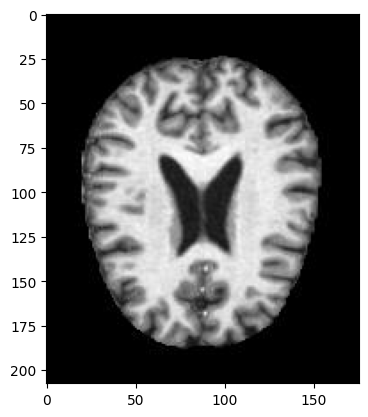

In [17]:
import cv2

image = cv2.imread('Alzheimer/test/NonDemented/26 (100).jpg')
plt.imshow(image)

We will now resize and reshape image so that our model can work perfectly with the image

In [18]:
image_resized = cv2.resize(image, (256, 256))
image_reshaped = image_resized.reshape((1, 256, 256, 3))

Now our model is doing prediction on the image
<br>It gives probability of each class. We take the class with highest probability (which turns out to be correct here)

In [19]:
classes[np.argmax(model.predict(image_reshaped))]

1/1 [==============================] - 0s 467ms/step


'NonDemented'

Probability of each class in our prediction

In [32]:
model.predict(image_reshaped)

1/1 [==============================] - 0s 51ms/step


array([[0.07574144, 0.00902073, 0.5588487 , 0.35638914]], dtype=float32)